Alden Bradford, February 2, 2022

From a preliminary look at the time-to-confirmation, one pattern immediately jumps out. For seven employers, some of their verifications happen within 30 seconds. These are distributed in a very different way from the other time-to-verification data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('/depot/tdm-musafe/apps')
from make_features import load_data
incidents, acceleration = load_data()

Let's first have a look at the data directly.

In [2]:
seconds = ((incidents['confirmation_ts'] - incidents['occurrence_ts'])/pd.Timedelta('1s')).astype('int').rename('Seconds to confirmation')
seconds.describe()

count    2.770000e+03
mean     3.570206e+05
std      1.875389e+06
min      0.000000e+00
25%      5.000000e+00
50%      2.314500e+03
75%      5.778175e+04
max      2.888262e+07
Name: Seconds to confirmation, dtype: float64

Since the times span multiple orders of magnitude, a logarithmic scale is necessary. However, many of them are exactly zero. We should exclude those from this plot.

<AxesSubplot:xlabel='Seconds to confirmation', ylabel='Count'>

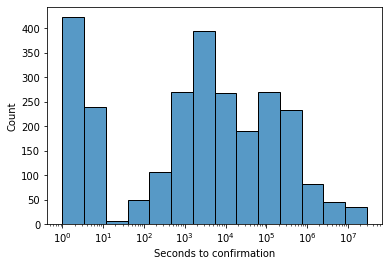

In [3]:
sns.histplot(seconds[seconds != 0], log_scale = True)

We can see a major dip in the distribution around 30 seconds. It becomes more clear what is happening when we segment the data.

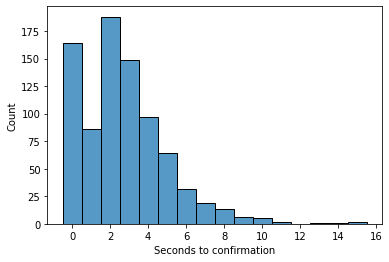

In [4]:
sns.histplot(seconds[seconds < 30], discrete = True)
plt.savefig('fast_confirmations.png')

We can see that the <30 second samples appear to follow a Poisson distribution, indicating that they may be the result of a random addative process.

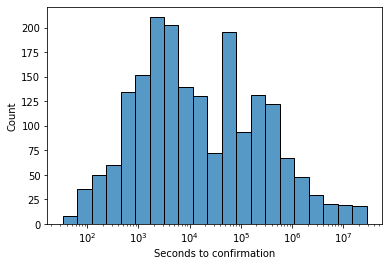

In [5]:
sns.histplot(seconds[seconds > 30], log_scale=True)
plt.savefig('slow_confirmations.png')

The times longer than 30 seconds appear to follow a log-normal distribution, though there is a heavy tail. There is a notable dip around 8 hours $\approx$ 30,000 seconds. It seems reasonable to attribute this to incidents which were not verified until the following workday.

Is there anything which stands out about those incidents which were confrimed very quickly? Let's do a short analysis:

In [6]:
(incidents[seconds < 30][['motion', 'hash_id']]
 .pivot_table(index='hash_id', columns='motion', aggfunc=len, fill_value=0, margins=True)
 .sort_values('All', ascending=False)
)

motion,fall,other,slip,trip,All
hash_id,,,,,
All,2,766,48,13,829
e81ad8a2e87bd88e4ff71d8da2c7a026,0,285,0,0,285
0c96025713b01a04beff5193cbf7d76d,1,213,42,11,267
39bf04098a77bb913f9bc5d641d0f9f9,1,197,3,0,201
f3af00480024c8e968798ab4524c3eb1,0,37,1,0,38
1bd47bc54ee0cf5ec88079d6a346d817,0,16,1,0,17
8ab702b0237a1f68aa821b8d4f8dc2ef,0,9,1,1,11
515e8ea766512d541bd64f50668952ae,0,9,0,1,10


One of the employers (e81ad8a2e87bd88e4ff71d8da2c7a026) is responsible for a large number of these fast events, but none of them are reported as hazardous. What kind of distribution do their times follow?

In [7]:
e8 = seconds[incidents['hash_id'] == 'e81ad8a2e87bd88e4ff71d8da2c7a026']
e8.describe()

count    2.890000e+02
mean     2.118761e+04
std      2.691959e+05
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      4.124738e+06
Name: Seconds to confirmation, dtype: float64

<AxesSubplot:xlabel='Seconds to confirmation', ylabel='Count'>

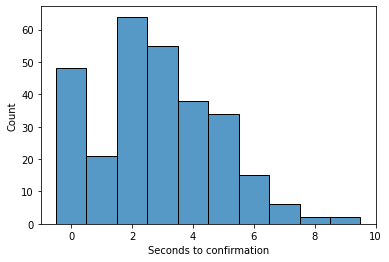

In [8]:
sns.histplot(e8[e8<30], discrete=True)

They do seem to have four longer events as well as their short ones. What are they?

In [9]:
e8[e8>30] * pd.Timedelta('1s')

incident_id
1741406    0 days 00:01:21
2576085    0 days 00:15:51
3730021   47 days 17:45:38
4256071   23 days 02:37:27
Name: Seconds to confirmation, dtype: timedelta64[ns]

One incident which took a minute and a half, one which took 15 minutes, and two which took around a month. When did these occur?

In [14]:
incidents.loc[e8[e8>30].index]

,hash_id,motion,occurrence_ts,confirmation_ts
incident_id,,,,
1741406,e81ad8a2e87bd88e4ff71d8da2c7a026,other,2020-11-19 12:44:32+00:00,2020-11-19 12:45:53+00:00
2576085,e81ad8a2e87bd88e4ff71d8da2c7a026,other,2021-01-27 00:18:05+00:00,2021-01-27 00:33:56+00:00
3730021,e81ad8a2e87bd88e4ff71d8da2c7a026,other,2021-03-25 20:14:45+00:00,2021-05-12 14:00:23+00:00
4256071,e81ad8a2e87bd88e4ff71d8da2c7a026,other,2021-04-19 16:26:07+00:00,2021-05-12 19:03:34+00:00


In [15]:
incidents.loc[e8[e8<30].index].occurrence_ts.max()

Timestamp('2020-10-31 01:54:10+0000', tz='UTC')

It looks like after November o